In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0))
])
train_data = MNIST(root = './dataset', download = True, train = True, transform = trans)

In [6]:
valid_data = MNIST(root = './dataset', download = True, train = False, transform = trans)

In [16]:
trainloader = DataLoader(train_data, batch_size = 256)
validloader = DataLoader(valid_data, batch_size = 256)
x, y = next(iter(trainloader))
print(x.shape)
print(y.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


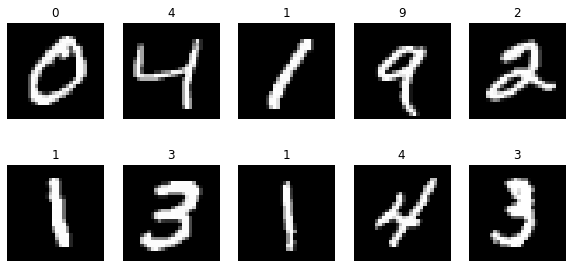

In [8]:
figure = plt.figure(figsize = (10, 10))
for i in range(1, 10+1):
    img, label = x[i], y[i].item()
    plt.subplot(4, 5, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.axis('off')
    plt.title(label)

In [ ]:
imgs, label = next(iter(trainloader))
layer1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5)
layer2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)

In [ ]:
weight1 = layer1.weight[:, 0, :, :].detach().numpy()
weight2 = layer2.weight[:, 0, :, :].detach().numpy()

print(weight1.shape)
print(weight2.shape)

(6, 5, 5)
(16, 5, 5)


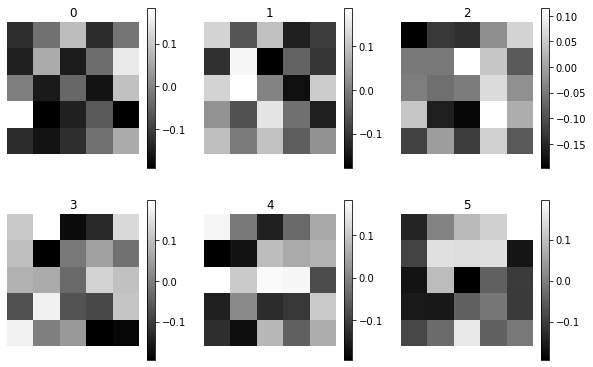

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(0, 5+ 1):
    plt.subplot(3, 3, i+1)
    plt.imshow(weight1[i], cmap = 'gray')
    plt.title(i)
    plt.axis('off')
    plt.colorbar()

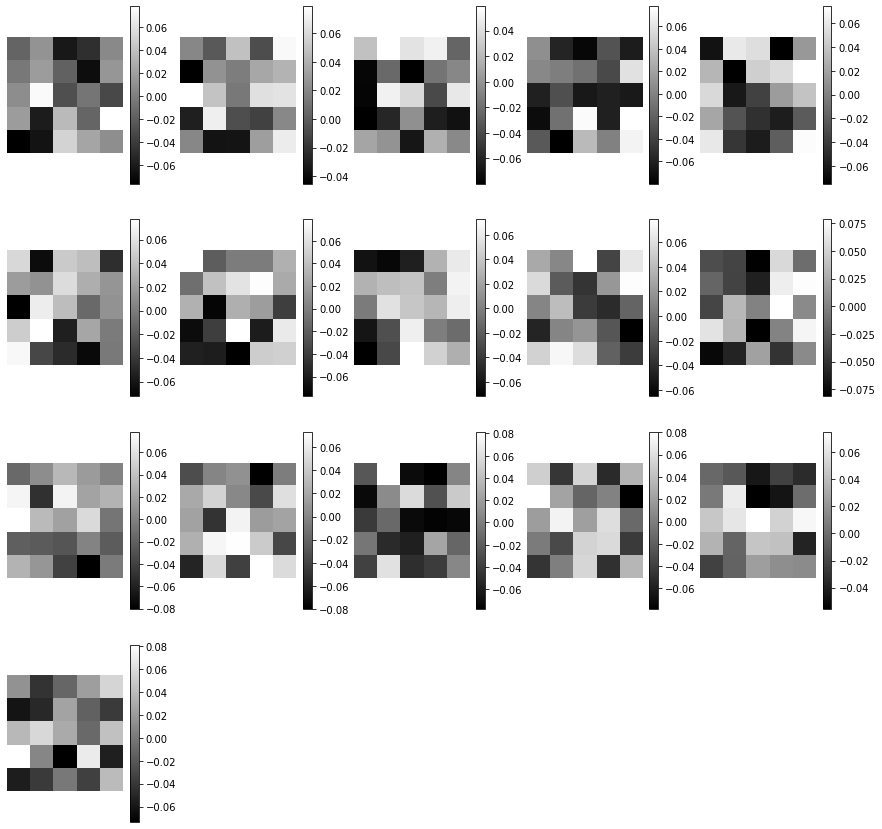

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(0, 15+1):
    plt.subplot(4, 5, i+1)
    plt.imshow(weight2[i], cmap = 'gray')
    plt.axis('off')
    plt.colorbar()

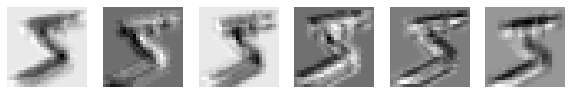

In [ ]:
plot_imgs = layer1(imgs)[0, :, :, :].detach().numpy()

plt.figure(figsize = (10, 10))
for i in range(5+1):
    plt.subplot(1, 6, i+1)
    plt.imshow(plot_imgs[i], cmap = 'gray')
    plt.axis('off')

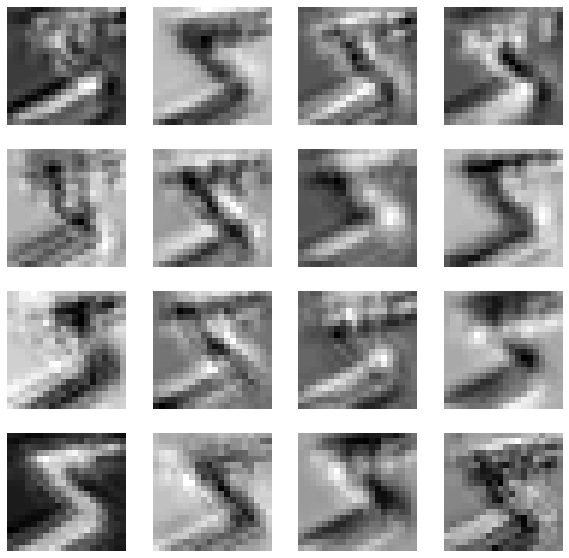

In [ ]:
plot_imgs2 = layer2((layer1(imgs)))[0, :, :, :].detach().numpy()

plt.figure(figsize = (10, 10))
for i in range(15 + 1):
    plt.subplot(4, 4, i+1)
    plt.imshow(plot_imgs2[i], cmap = 'gray')
    plt.axis('off')

In [9]:
class Lenet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5)
        self.s2 = nn.MaxPool2d(2)
        self.c3 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.s4 = nn.MaxPool2d(2)
        self.c5 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 4)
        self.fc1 = nn.Linear(1 * 1 * 120, 84)
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = torch.tanh(self.c1(x))
        x = self.s2(x)
        x = torch.tanh(self.c3(x))
        x = self.s4(x)
        x = torch.tanh(self.c5(x))
        x = x.view(-1, 120)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

In [29]:
model = Lenet().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [32]:
from torchsummary import summary
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Conv2d-5            [-1, 120, 1, 1]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [39]:
def metric_batch(output, target):
  pred = output.argmax(1)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [34]:
def loss_batch(loss_func, output, target, opt = None):
  loss_b = loss_func(output, target)
  metric_b = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss_b.backward()
    opt.step()

  return loss_b.item(), metric_b

In [42]:
def loss_epoch(model,  loss_func, dataloader, device, opt = None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataloader)

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    output = model(imgs)

    loss_b, metric_b = loss_batch(loss_func, output, labels, opt = opt)
    
    running_loss += loss_b
    if metric_b is not None:
      running_metric += metric_b

  loss = running_loss / len_data
  metric = running_metric / len_data

  return loss, metric

In [43]:
def train_and_val(model, params):
  num_epochs = params['num_epochs']
  loss_func = params['loss_func']
  opt = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params['val_dl']

  loss_history = {'train': [], 'val' :[]}
  metric_history = {'train' : [], 'val' :[]}

  start_time = time.time()
  best_loss = float('inf')

  for epoch in range(num_epochs):
    model.train()

    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, device, opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    model.eval()
    print('EPOCH : ', epoch, 'LOSS : {:.4f}'.format(train_loss), 'METRIC : {:.3f}'.format(train_metric))

    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, device)
      loss_history['val'].append(val_loss)
      metric_history['val'].append(val_metric)

      if val_loss < best_loss:
        best_loss = val_loss
        print('Have a best Model')
        print('EPOCH : ', epoch, 'LOSS : {:.4f}'.format(val_loss), 'METRIC : {:.3f}'.format(val_metric))

  return model, loss_history, metric_history

In [44]:
params = {
    'num_epochs':30,
    'optimizer' : optim,
    'loss_func' : loss_fn,
    'train_dl' : trainloader,
    'val_dl' : validloader
}

In [45]:
model, loss_hist, metric_hist = train_and_val(model, params)

EPOCH :  0 LOSS : 1.7431 METRIC : 193.489
Have a best Model
EPOCH :  0 LOSS : 1.5555 METRIC : 213.525
EPOCH :  1 LOSS : 1.5312 METRIC : 223.102
Have a best Model
EPOCH :  1 LOSS : 1.5104 METRIC : 221.000
EPOCH :  2 LOSS : 1.5064 METRIC : 233.996
Have a best Model
EPOCH :  2 LOSS : 1.4990 METRIC : 237.700
EPOCH :  3 LOSS : 1.4896 METRIC : 248.609
Have a best Model
EPOCH :  3 LOSS : 1.4833 METRIC : 244.350
EPOCH :  4 LOSS : 1.4809 METRIC : 250.387
Have a best Model
EPOCH :  4 LOSS : 1.4798 METRIC : 245.050
EPOCH :  5 LOSS : 1.4773 METRIC : 251.128
Have a best Model
EPOCH :  5 LOSS : 1.4773 METRIC : 245.700
EPOCH :  6 LOSS : 1.4747 METRIC : 251.757
Have a best Model
EPOCH :  6 LOSS : 1.4758 METRIC : 246.125
EPOCH :  7 LOSS : 1.4728 METRIC : 252.209
Have a best Model
EPOCH :  7 LOSS : 1.4748 METRIC : 246.175
EPOCH :  8 LOSS : 1.4713 METRIC : 252.600
Have a best Model
EPOCH :  8 LOSS : 1.4747 METRIC : 246.400
EPOCH :  9 LOSS : 1.4700 METRIC : 252.987
Have a best Model
EPOCH :  9 LOSS : 1.47

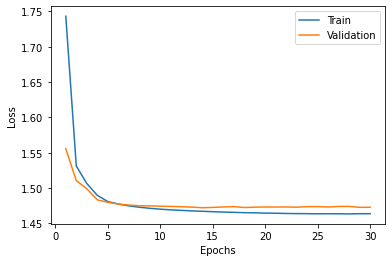

In [47]:

plt.plot(range(1, 30+1), loss_hist['train'],label = 'Train')
plt.plot(range(1, 30+1), loss_hist['val'],label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

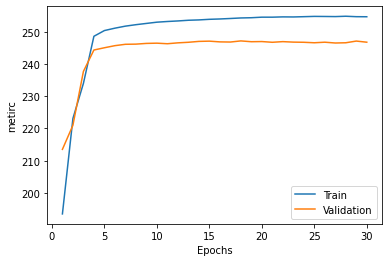

In [49]:

plt.plot(range(1, 30+1), metric_hist['train'],label = 'Train')
plt.plot(range(1, 30+1), metric_hist['val'],label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('metirc')
plt.legend()